In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals  

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

import IPython

sns.set(color_codes=True)

num_seeds = 41
test_idx=6558
# 1173, 4644 good. 1891, 4936 bad. 1735, 3562 controversial
top_points = [1173, 4644, 1891, 4936, 1735, 3562]
types = ['Good', 'Good', 'Bad', 'Bad', 'Controversial', 'Controversial']
num_top_points = len(top_points)

def ceil_divide(numer,denom):
    return (numer-1)//denom+1

In [2]:
f = np.load('../../output/mnist_small_all_cnn_c_hidden2_seed40_iter-300000_remove_3562_0-{}seeds_complete_retrain_losses_and_actuals-test-{}-points-{}.npz'.format(num_seeds-1,[test_idx],top_points))
loss_remove_one = f['loss_remove_one']
loss_remove_one_ps = [row.values() for row in loss_remove_one]
loss_remove_one_ps = np.transpose(np.array(loss_remove_one_ps))
actual_retrain_loss_diffs = f['actual_retrain_loss_diffs']
actual_retrain_loss_diffs_ps = [row.values() for row in actual_retrain_loss_diffs]
actual_retrain_loss_diffs_ps = np.transpose(np.array(actual_retrain_loss_diffs_ps))

f = np.load('../../output/0-{}seeds_test-{}_loss_and_correctness_and_preds.npz'.format(num_seeds-1,[test_idx]))
loss_full = f['loss_full']
correct = f['correct']
predicted_loss_diffs = f['predicted_loss_diffs']

# correct[seed]:
#   -- Whether the full model correctly predicted test_idx with |seed|
# loss_full[seed]:
#   -- Full model's loss on test_idx with |seed|
# loss_remove_one[seed][point]:
#   -- Completely retrained model's loss on test_idx with |seed| w/o |point|
# actual_retrain_loss_diffs[seed][point]: 
#   -- Diff btw full model and completely retrained model's losses on test_idx with |seed| w/o |point|
#   -- This is the ACTUAL influence!
# predicted_loss_diffs[seed][point]:
#   -- This is the predicted influence on test_idx with |seed| of |point|,
#          calculated via influence functions and linear/quadratic approximations

# It's good to keep in mind the plot of predicted vs fake actual influences in hidden2_seeds.ipynb / hidden2_seeds.png

In [3]:
"""for seed in range(1,1+num_seeds):
    print("Seed {}:".format(seed))
    for point in top_points:
        print("Point {}: Predicted {}, Actual {}".format(point, predicted_loss_diffs[seed][point],actual_retrain_loss_diffs[seed][point]))
        print("          Loss_full {}, Loss_remove_one {}".format(loss_full[seed],loss_remove_one[seed][point]))
    print("-------------------------")
"""

u'for seed in range(1,1+num_seeds):\n    print("Seed {}:".format(seed))\n    for point in top_points:\n        print("Point {}: Predicted {}, Actual {}".format(point, predicted_loss_diffs[seed][point],actual_retrain_loss_diffs[seed][point]))\n        print("          Loss_full {}, Loss_remove_one {}".format(loss_full[seed],loss_remove_one[seed][point]))\n    print("-------------------------")\n'

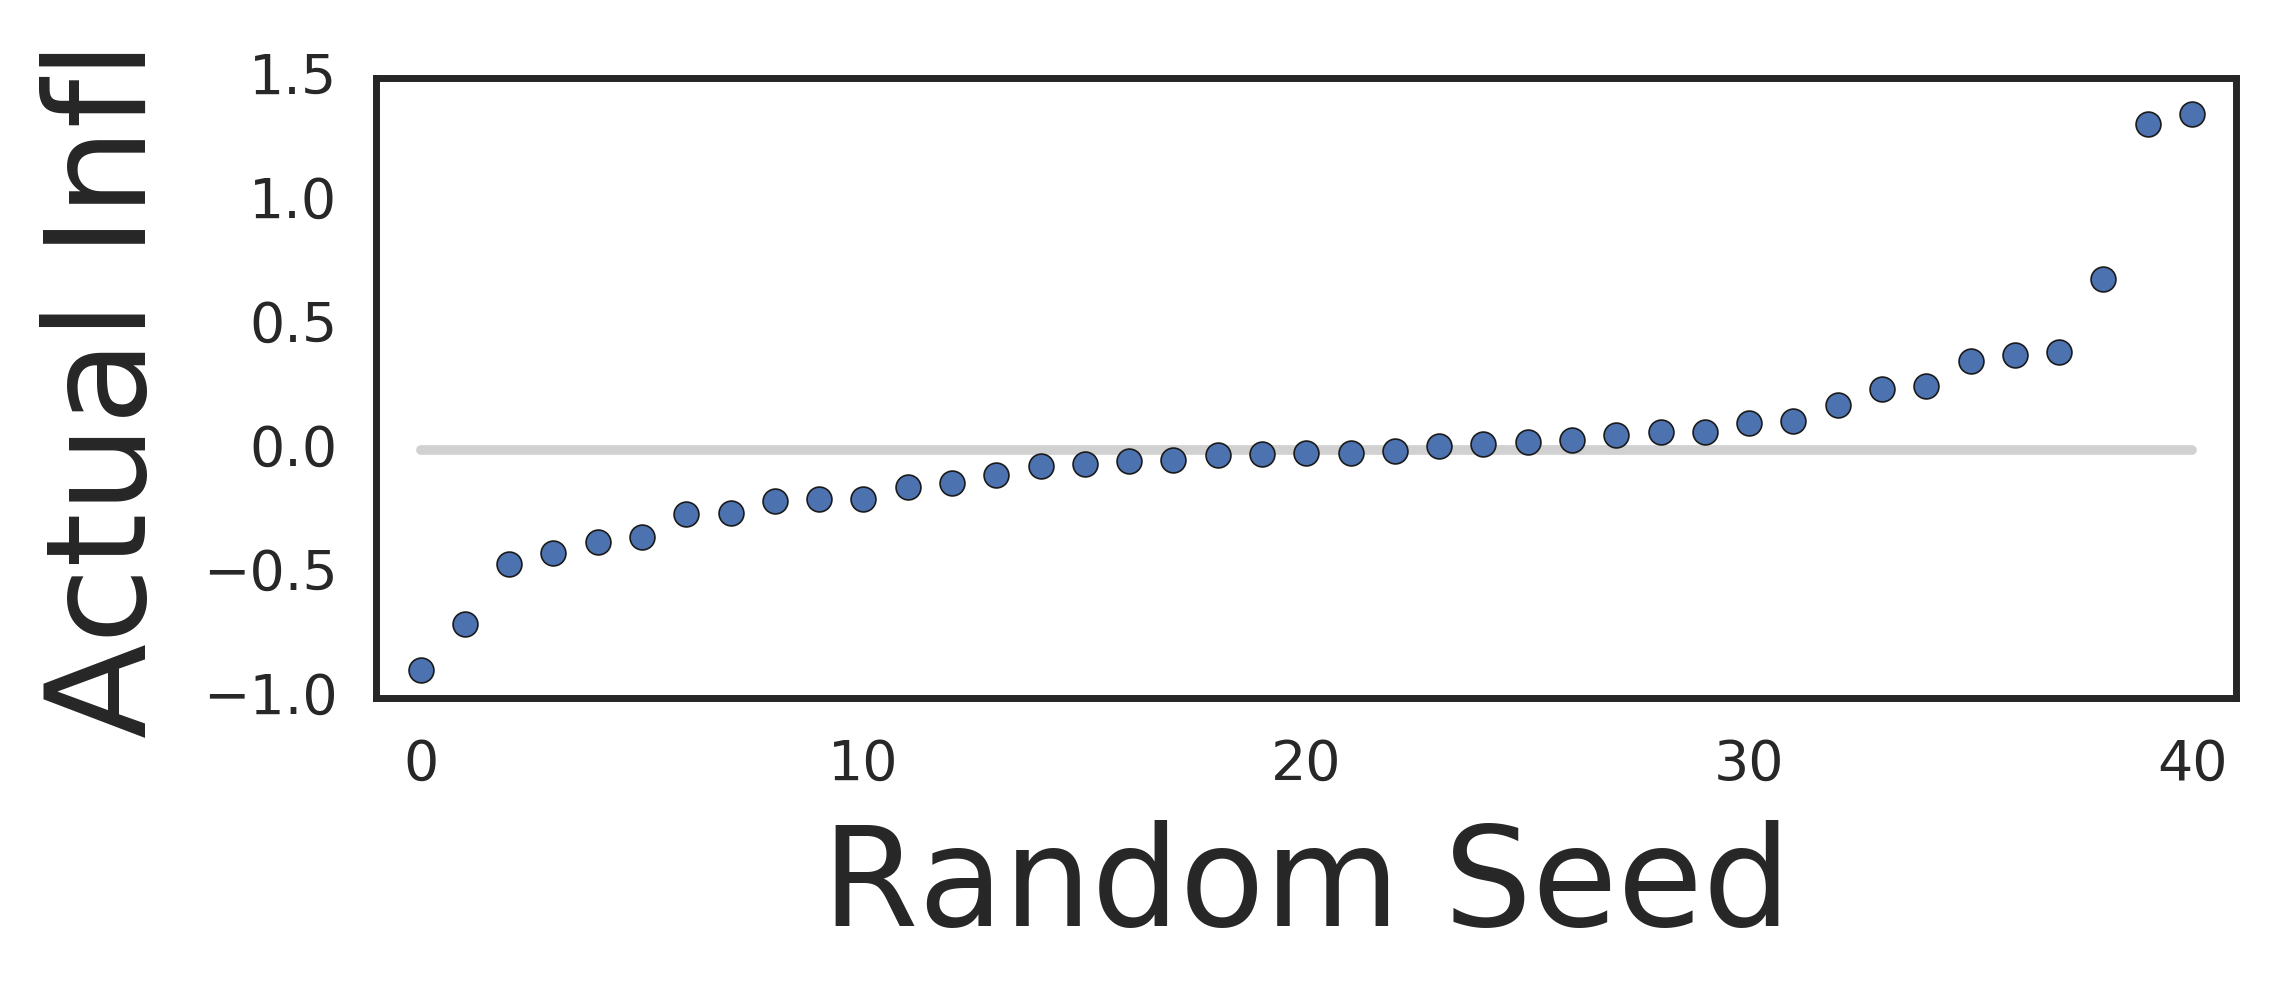

In [6]:
fontsize=25
sns.set_style('white')
fig, axs = plt.subplots(1,1,figsize=(6,2),dpi=400)
axs.scatter(range(num_seeds), np.sort(actual_retrain_loss_diffs_ps[0]), zorder=5, label='Actual')
axs.plot([0,40],[0,0],color='k',alpha=0.2)
axs.set_xlabel('Random Seed',fontsize=fontsize)
axs.set_ylabel('Actual Infl',fontsize=fontsize)
axs.set_xlim(-1,41)
axs.set_ylim(-1,1.5)
plt.savefig('MNIST_pt1173_actual_infls.png',dpi=400)

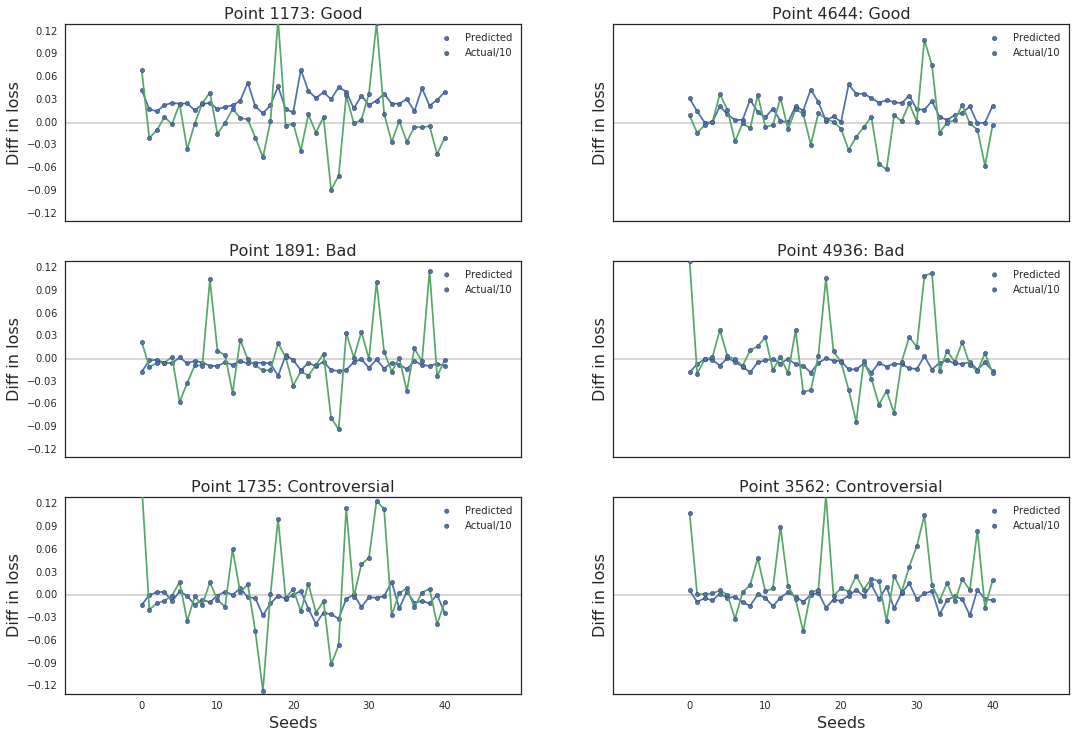

In [3]:
scale_factor = 10

sns.set_style('white')
fontsize=16
width = 2
height = ceil_divide(num_top_points,width)
fig, axs = plt.subplots(height, width, sharex=True, sharey=True, figsize=(6*height, 6*width))

for row in axs: 
    #row[0].set_ylabel('Diff in loss', fontsize=fontsize)
    for ax in row:
        ax.set_ylabel('Diff in loss', fontsize=fontsize)
        ax.set_aspect(100)
        ax.set_xticks(np.arange(0, num_seeds, max(int(num_seeds/4),1)))
        ax.set_yticks(np.arange(-0.12, 0.13, 0.03))
        ax.set_xlim([-1,num_seeds])
        ax.set_ylim([-0.13, 0.13])
        #ax.set_xlabel('Seeds', fontsize=fontsize)
for col in axs[-1]:
    col.set_xlabel('Seeds', fontsize=fontsize)
    
for i, row in enumerate(axs):
    for j, ax in enumerate(row):
        ind = len(row)*i+j
        if ind < num_top_points:
            point = top_points[ind]
            ax.axhline(color='k',alpha=0.2,zorder=1)
            ax.plot(range(num_seeds), predicted_loss_diffs[:,point], zorder=2)
            ax.scatter(range(num_seeds), predicted_loss_diffs[:,point], zorder=3, label='Predicted')
            scaled_actual = np.divide(actual_retrain_loss_diffs_ps[ind], scale_factor)
            ax.plot(range(num_seeds), scaled_actual, zorder=4)
            ax.scatter(range(num_seeds), scaled_actual, zorder=5, label='Actual/{}'.format(scale_factor))
            ax.set_title('Point {}: {}'.format(point, types[ind]), fontsize=fontsize)
            ax.legend()

plt.savefig('hidden2_seeds_complete_retrain_pred_actual_new.png', dpi=400, bbox_inches='tight')

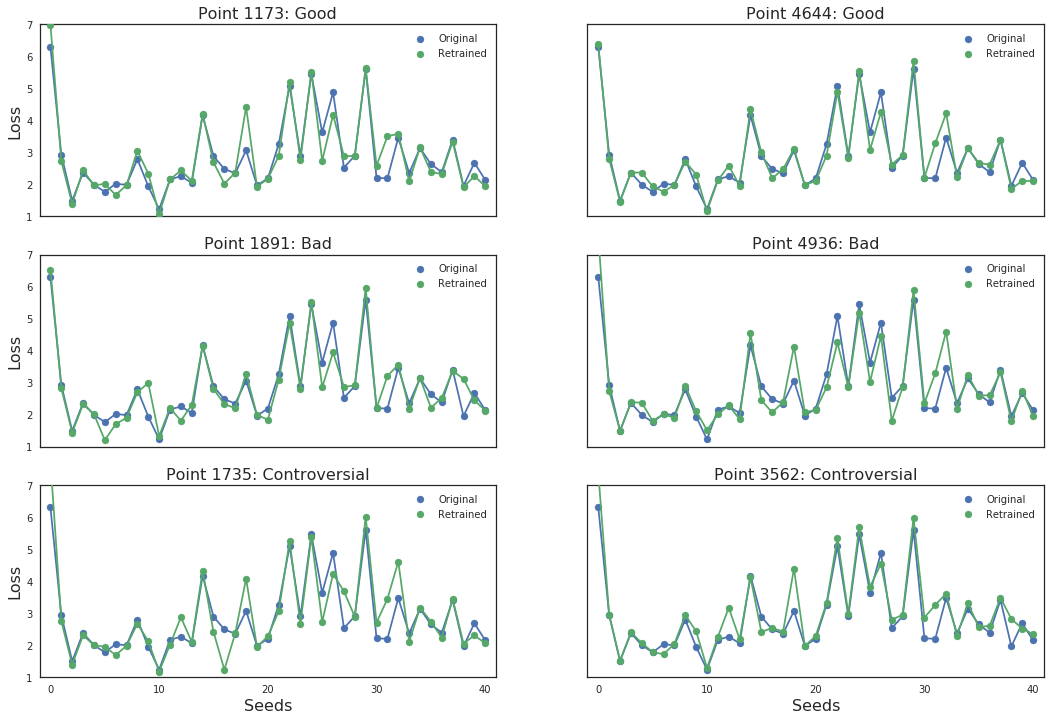

In [8]:
sns.set_style('white')
fontsize=16
width = 2
height = ceil_divide(num_top_points,width)
fig, axs = plt.subplots(height, width, sharex=True, sharey=True, figsize=(6*height, 6*width))

for row in axs: 
    row[0].set_ylabel('Loss', fontsize=fontsize)
    for ax in row:
        ax.set_aspect('auto')
        ax.set_xticks(np.arange(0, num_seeds, max(int(num_seeds/4),1)))
        ax.set_yticks(np.arange(1, 8, 1))
        ax.set_xlim([-1,num_seeds])
        ax.set_ylim([1, 7])
for col in axs[-1]:
    col.set_xlabel('Seeds', fontsize=fontsize)
    
for i, row in enumerate(axs):
    for j, ax in enumerate(row):
        ind = len(row)*i+j
        if ind < num_top_points:
            point = top_points[ind]
            #ax.axhline(color='k',alpha=0.2,zorder=1)
            ax.plot(range(num_seeds), loss_full, zorder=2)
            ax.scatter(range(num_seeds), loss_full, zorder=3, label='Original')
            ax.plot(range(num_seeds), loss_remove_one_ps[ind], zorder=4)
            ax.scatter(range(num_seeds), loss_remove_one_ps[ind], zorder=5, label='Retrained')
            ax.set_title('Point {}: {}'.format(point, types[ind]), fontsize=fontsize)
            ax.legend()

plt.savefig('../../scr/figs/hidden2_seeds_complete_retrain_losses_new.png', dpi=600, bbox_inches='tight')